In [1]:
!pip install yacs
!pip install gdown

In [2]:
import os, sys, time
import argparse
import importlib
from tqdm.notebook import tqdm
from imageio import imread
import torch
import numpy as np
import matplotlib.pyplot as plt

### Download pretrained
- We use HoHoNet w/ hardnet encoder in this demo
- Download other version [here](https://drive.google.com/drive/folders/1raT3vRXnQXRAQuYq36dE-93xFc_hgkTQ?usp=sharing)

In [3]:
PRETRAINED_PTH = 'ckpt/mp3d_layout_HOHO_layout_aug_efficienthc_Transen1_resnet34/ep300.pth'

if not os.path.exists(PRETRAINED_PTH):
    os.makedirs(os.path.split(PRETRAINED_PTH)[0], exist_ok=True)
    !gdown 'https://drive.google.com/uc?id=1OU9uyuNiswkPovJuvG3sevm3LqHJgazJ' -O $PRETRAINED_PTH

### Download image
- We use a out-of-distribution image from PanoContext

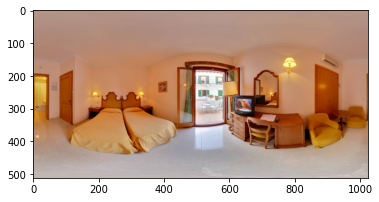

In [4]:
if not os.path.exists('assets/pano_asmasuxybohhcj.png'):
    !gdown 'https://drive.google.com/uc?id=1CXl6RPK6yPRFXxsa5OisHV9KwyRcejHu' -O 'assets/pano_asmasuxybohhcj.png'

rgb = imread('assets/pano_asmasuxybohhcj.png')

plt.imshow(rgb)
plt.show()

### Load model config
- We use HoHoNet w/ hardnet encoder in this demo
- Find out other version in `mp3d_depth/` and `s2d3d_depth`

In [5]:
from lib.config import config

config.defrost()
config.merge_from_file('config/mp3d_layout/HOHO_layout_aug_efficienthc_Transen1_resnet34.yaml')
config.freeze()

### Load model

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('devcie:', device)

model_file = importlib.import_module(config.model.file)
model_class = getattr(model_file, config.model.modelclass)
net = model_class(**config.model.kwargs)
net.load_state_dict(torch.load(PRETRAINED_PTH, map_location=device))
net = net.eval().to(device)

devcie: cpu


### Move image into tensor, normzlie to [0, 255], resize to 512x1024

In [7]:
x = torch.from_numpy(rgb).permute(2,0,1)[None].float() / 255.
if x.shape[2:] != (512, 1024):
    x = torch.nn.functional.interpolate(x, self.hw, mode='area')
x = x.to(device)

### Model feedforward

In [8]:
with torch.no_grad():
    ts = time.time()
    layout = net.infer(x)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    print(f'Eps time: {time.time() - ts:.2f} sec.')

cor_id = layout['cor_id']
y_bon_ = layout['y_bon_']
y_cor_ = layout['y_cor_']

Eps time: 1.92 sec.


### Visualize result in 2d

In [9]:
from eval_layout import layout_2_depth

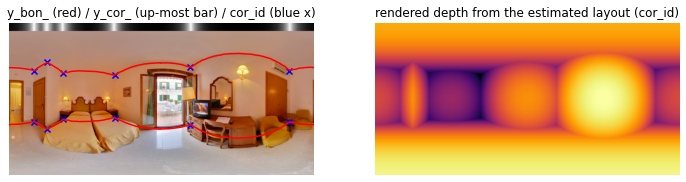

In [10]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.imshow(np.concatenate([
    (y_cor_ * 255).reshape(1,-1,1).repeat(30, 0).repeat(3, 2).astype(np.uint8),
    rgb[30:]
], 0))
plt.plot(np.arange(y_bon_.shape[1]), y_bon_[0], 'r-')
plt.plot(np.arange(y_bon_.shape[1]), y_bon_[1], 'r-')
plt.scatter(cor_id[:, 0], cor_id[:, 1], marker='x', c='b')
plt.axis('off')
plt.title('y_bon_ (red) / y_cor_ (up-most bar) / cor_id (blue x)')

plt.subplot(122)
plt.imshow(layout_2_depth(cor_id, *rgb.shape[:2]), cmap='inferno_r')
plt.axis('off')
plt.title('rendered depth from the estimated layout (cor_id)')

plt.show()

### Visualize result as 3d mesh

In [ ]:
!pip install open3d
!pip install plotly

In [ ]:
import open3d as o3d
import plotly.graph_objects as go
from scipy.signal import correlate2d
from scipy.ndimage import shift
from skimage.transform import resize

from lib.misc.post_proc import np_coor2xy, np_coorx2u, np_coory2v

In [ ]:
H, W = 256, 512
ignore_floor = False
ignore_ceiling = True
ignore_wall = False

In [ ]:
# Convert corners to layout
depth, floor_mask, ceil_mask, wall_mask = [
    resize(v, [H, W], order=0, preserve_range=True).astype(v.dtype)
    for v in layout_2_depth(cor_id, *rgb.shape[:2], return_mask=True)]
coorx, coory = np.meshgrid(np.arange(W), np.arange(H))
us = np_coorx2u(coorx, W)
vs = np_coory2v(coory, H)
zs = depth * np.sin(vs)
cs = depth * np.cos(vs)
xs = cs * np.sin(us)
ys = -cs * np.cos(us)

# Aggregate mask
mask = np.ones_like(floor_mask)
if ignore_floor:
    mask &= ~floor_mask
if ignore_ceiling:
    mask &= ~ceil_mask
if ignore_wall:
    mask &= ~wall_mask

# Prepare ply's points and faces
xyzrgb = np.concatenate([
    xs[...,None], ys[...,None], zs[...,None],
    resize(rgb, [H, W])], -1)
xyzrgb = np.concatenate([xyzrgb, xyzrgb[:,[0]]], 1)
mask = np.concatenate([mask, mask[:,[0]]], 1)
lo_tri_template = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 1, 1]])
up_tri_template = np.array([
    [0, 0, 0],
    [0, 1, 1],
    [0, 0, 1]])
ma_tri_template = np.array([
    [0, 0, 0],
    [0, 1, 1],
    [0, 1, 0]])
lo_mask = (correlate2d(mask, lo_tri_template, mode='same') == 3)
up_mask = (correlate2d(mask, up_tri_template, mode='same') == 3)
ma_mask = (correlate2d(mask, ma_tri_template, mode='same') == 3) & (~lo_mask) & (~up_mask)
ref_mask = (
    lo_mask | (correlate2d(lo_mask, np.flip(lo_tri_template, (0,1)), mode='same') > 0) |\
    up_mask | (correlate2d(up_mask, np.flip(up_tri_template, (0,1)), mode='same') > 0) |\
    ma_mask | (correlate2d(ma_mask, np.flip(ma_tri_template, (0,1)), mode='same') > 0)
)
points = xyzrgb[ref_mask]

ref_id = np.full(ref_mask.shape, -1, np.int32)
ref_id[ref_mask] = np.arange(ref_mask.sum())
faces_lo_tri = np.stack([
    ref_id[lo_mask],
    ref_id[shift(lo_mask, [1, 0], cval=False, order=0)],
    ref_id[shift(lo_mask, [1, 1], cval=False, order=0)],
], 1)
faces_up_tri = np.stack([
    ref_id[up_mask],
    ref_id[shift(up_mask, [1, 1], cval=False, order=0)],
    ref_id[shift(up_mask, [0, 1], cval=False, order=0)],
], 1)
faces_ma_tri = np.stack([
    ref_id[ma_mask],
    ref_id[shift(ma_mask, [1, 0], cval=False, order=0)],
    ref_id[shift(ma_mask, [0, 1], cval=False, order=0)],
], 1)
faces = np.concatenate([faces_lo_tri, faces_up_tri, faces_ma_tri])

In [ ]:
fig = go.Figure(
    data=[
        go.Mesh3d(
            x=points[:,0],
            y=points[:,1],
            z=points[:,2],
            i=faces[:,0],
            j=faces[:,1],
            k=faces[:,2],
            facecolor=points[:,3:][faces[:,0]])
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)
fig.show()